In [3]:
import pandas as pd
import datetime as dt
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

my_date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [4]:
listings = pd.read_csv('data/listings.csv')
listings_full = pd.read_csv('data/listings-full.csv')
reviews = pd.read_csv('data/reviews.csv', parse_dates=['date'],
                      date_parser=my_date_parser)
reviews_full = pd.read_csv('data/reviews-full.csv', parse_dates=['date'], 
                           date_parser=my_date_parser)
neighbourhoods = pd.read_csv('data/neighbourhoods.csv')
rents = pd.read_excel('data/voa-average-rent-borough.xls', 
                      sheet_name='Raw data', header=2)

C:\Users\alkonone\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3-b61fc52f2063>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  my_date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')


In [5]:
# If availability is zero, host has set the apartment as not available. 
# Script calculates income based on availability so these are erased from the dataframe.
available_listings = listings[listings['availability_365'] != 0]

available_listings = pd.merge(available_listings, listings_full[['id', 'bedrooms']], 
                              how='left', on='id')
available_listings.head()

id                                               name  host_id  \
0  13913                Holiday London DB Room Let-on going    54730   
1  15400                Bright Chelsea  Apartment. Chelsea!    60302   
2  17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1    67564   
3  17506  Boutique Chelsea/Fulham Double bed 5-star ensuite    67915   
4  25023      All-comforts 2-bed flat near Wimbledon tennis   102813   

   host_name  neighbourhood_group           neighbourhood  latitude  \
0      Alina                  NaN               Islington  51.56802   
1   Philippa                  NaN  Kensington and Chelsea  51.48796   
2        Liz                  NaN             Westminster  51.52195   
3  Charlotte                  NaN  Hammersmith and Fulham  51.47935   
4     Amanda                  NaN              Wandsworth  51.44687   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -0.11121     Private room     65               1                 21   
1   -0.16898  Entire home/apt    100              10                 89   
2   -0.14094  Entire home/apt    300               3                 42   
3   -0.19743     Private room    150               3                  0   
4   -0.21874  Entire home/apt     65              21                 35   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2020-02-22               0.18                               2   
1  2020-03-16               0.71                               1   
2  2019-11-02               0.38                              15   
3         NaN                NaN                               2   
4  2020-03-30               0.70                               1   

   availability_365  bedrooms  
0               359       1.0  
1               232       1.0  
2               307       3.0  
3               362       1.0  
4                15       2.0

In [6]:
# Setting the bedroom count as int in the rents dataframe

def bedrooms_to_int(bedrooms):
    if bedrooms == 'One Bedroom':
        return 1
    elif bedrooms == 'Two Bedroom':
        return 2
    elif bedrooms == 'Three Bedroom':
        return 3
    elif bedrooms == 'Four or more Bedrooms':
        return 4
    else:
        return np.nan
    

possible_categories = ['One Bedroom', 'Two Bedroom', 'Three Bedroom','Four or more Bedrooms', 'All categories']
# rents datframe uses - . and .. to recognice null value cells
rents = rents[(rents.Year == 2019) & (rents.Category.isin(possible_categories))].replace(['-','.','..'], np.nan).dropna()

rents['bedrooms'] = rents.apply(lambda row: bedrooms_to_int(row.Category), axis = 1)
rents.head()

Year Quarter       Code                  Area     Category  \
5940  2019      Q1  E09000001        City of London  One Bedroom   
5941  2019      Q1  E09000002  Barking and Dagenham  One Bedroom   
5942  2019      Q1  E09000003                Barnet  One Bedroom   
5943  2019      Q1  E09000004                Bexley  One Bedroom   
5944  2019      Q1  E09000005                 Brent  One Bedroom   

      Count of rents  Average  Lower quartile  Median  Upper quartile  \
5940            40.0   2083.0          1733.0  1950.0          2383.0   
5941           210.0    965.0           875.0   950.0          1050.0   
5942           620.0   1147.0          1049.0  1150.0          1250.0   
5943           150.0    821.0           750.0   825.0           900.0   
5944           400.0   1241.0          1100.0  1250.0          1352.0   

      bedrooms  
5940       1.0  
5941       1.0  
5942       1.0  
5943       1.0  
5944       1.0

In [7]:
# Estimating the host rent by neighbourhood and bedroom count

def estimate_rent(hood, bedrooms, rents):
    
    rent = rents[(rents.Area == hood) & (rents.bedrooms == bedrooms)]
    if len(rent.index) == 1:
        estimation = rent.iloc[0]['Median']
    else:
        rent = rents[(rents.Area == hood) & (rents.Category == 'All categories')]
        estimation=  rent.iloc[0]['Median']
    
    # 1 GBP = 1,24 USD
    estimation = float(estimation)*1.24
    return estimation

available_listings['host_rent'] = available_listings.apply(lambda row: estimate_rent(row.neighbourhood, row.bedrooms, rents), axis=1)
available_listings.head()

id                                               name  host_id  \
0  13913                Holiday London DB Room Let-on going    54730   
1  15400                Bright Chelsea  Apartment. Chelsea!    60302   
2  17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1    67564   
3  17506  Boutique Chelsea/Fulham Double bed 5-star ensuite    67915   
4  25023      All-comforts 2-bed flat near Wimbledon tennis   102813   

   host_name  neighbourhood_group           neighbourhood  latitude  \
0      Alina                  NaN               Islington  51.56802   
1   Philippa                  NaN  Kensington and Chelsea  51.48796   
2        Liz                  NaN             Westminster  51.52195   
3  Charlotte                  NaN  Hammersmith and Fulham  51.47935   
4     Amanda                  NaN              Wandsworth  51.44687   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -0.11121     Private room     65               1                 21   
1   -0.16898  Entire home/apt    100              10                 89   
2   -0.14094  Entire home/apt    300               3                 42   
3   -0.19743     Private room    150               3                  0   
4   -0.21874  Entire home/apt     65              21                 35   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2020-02-22               0.18                               2   
1  2020-03-16               0.71                               1   
2  2019-11-02               0.38                              15   
3         NaN                NaN                               2   
4  2020-03-30               0.70                               1   

   availability_365  bedrooms  host_rent  
0               359       1.0    1860.00  
1               232       1.0    2418.00  
2               307       3.0    4299.08  
3               362       1.0    1745.92  
4                15       2.0    2108.00

In [8]:
available_listings['yearly_income'] = available_listings.apply(lambda row: (365 - row.availability_365) * row.price, axis=1)

available_listings['yearly_profit'] = available_listings.apply(lambda row: row.yearly_income - (row.host_rent * 12), axis=1)


available_listings.head()

id                                               name  host_id  \
0  13913                Holiday London DB Room Let-on going    54730   
1  15400                Bright Chelsea  Apartment. Chelsea!    60302   
2  17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1    67564   
3  17506  Boutique Chelsea/Fulham Double bed 5-star ensuite    67915   
4  25023      All-comforts 2-bed flat near Wimbledon tennis   102813   

   host_name  neighbourhood_group           neighbourhood  latitude  \
0      Alina                  NaN               Islington  51.56802   
1   Philippa                  NaN  Kensington and Chelsea  51.48796   
2        Liz                  NaN             Westminster  51.52195   
3  Charlotte                  NaN  Hammersmith and Fulham  51.47935   
4     Amanda                  NaN              Wandsworth  51.44687   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -0.11121     Private room     65               1                 21   
1   -0.16898  Entire home/apt    100              10                 89   
2   -0.14094  Entire home/apt    300               3                 42   
3   -0.19743     Private room    150               3                  0   
4   -0.21874  Entire home/apt     65              21                 35   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2020-02-22               0.18                               2   
1  2020-03-16               0.71                               1   
2  2019-11-02               0.38                              15   
3         NaN                NaN                               2   
4  2020-03-30               0.70                               1   

   availability_365  bedrooms  host_rent  yearly_income  yearly_profit  
0               359       1.0    1860.00            390      -21930.00  
1               232       1.0    2418.00          13300      -15716.00  
2               307       3.0    4299.08          17400      -34188.96  
3               362       1.0    1745.92            450      -20501.04  
4                15       2.0    2108.00          22750       -2546.00

In [ ]:
listing_ids = pd.unique(available_listings['id'])


reviews_full = reviews_full[reviews_full.listing_id.isin(listing_ids)]

def get_sentiment(text):
    if type(text) is str:
        analysis = TextBlob(text)
    else:
        return 0
    return analysis.sentiment.polarity

reviews_full['review_sentiment'] = reviews_full.apply(lambda row: get_sentiment(row.comments), axis=1)
reviews_full.head(10)

In [10]:
reviews_full = reviews_full[['listing_id', 'review_sentiment']].groupby('listing_id').mean()
available_listings = pd.merge(available_listings, reviews_full, how='left', right_index=True, left_on='id')
available_listings = pd.merge(available_listings, listings_full[['id', 'review_scores_rating']], how='left', on='id')

available_listings.head()

id                                               name  host_id  \
0  13913                Holiday London DB Room Let-on going    54730   
1  15400                Bright Chelsea  Apartment. Chelsea!    60302   
2  17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1    67564   
3  17506  Boutique Chelsea/Fulham Double bed 5-star ensuite    67915   
4  25023      All-comforts 2-bed flat near Wimbledon tennis   102813   

   host_name  neighbourhood_group           neighbourhood  latitude  \
0      Alina                  NaN               Islington  51.56802   
1   Philippa                  NaN  Kensington and Chelsea  51.48796   
2        Liz                  NaN             Westminster  51.52195   
3  Charlotte                  NaN  Hammersmith and Fulham  51.47935   
4     Amanda                  NaN              Wandsworth  51.44687   

   longitude        room_type  price  ...  last_review  reviews_per_month  \
0   -0.11121     Private room     65  ...   2020-02-22               0.18   
1   -0.16898  Entire home/apt    100  ...   2020-03-16               0.71   
2   -0.14094  Entire home/apt    300  ...   2019-11-02               0.38   
3   -0.19743     Private room    150  ...          NaN                NaN   
4   -0.21874  Entire home/apt     65  ...   2020-03-30               0.70   

  calculated_host_listings_count  availability_365  bedrooms  host_rent  \
0                              2               359       1.0    1860.00   
1                              1               232       1.0    2418.00   
2                             15               307       3.0    4299.08   
3                              2               362       1.0    1745.92   
4                              1                15       2.0    2108.00   

   yearly_income  yearly_profit  review_sentiment  review_scores_rating  
0            390      -21930.00          0.394466                  97.0  
1          13300      -15716.00          0.367643                  96.0  
2          17400      -34188.96          0.320084                  94.0  
3            450      -20501.04               NaN                   NaN  
4          22750       -2546.00          0.359056                  93.0  

[5 rows x 22 columns]

In [11]:
available_listings.isna().sum()

id                                    0
name                                  2
host_id                               0
host_name                             5
neighbourhood_group               52245
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       11980
reviews_per_month                 11980
calculated_host_listings_count        0
availability_365                      0
bedrooms                            107
host_rent                             0
yearly_income                         0
yearly_profit                         0
review_sentiment                  11980
review_scores_rating              12752
dtype: int64

In [12]:
available_listings_with_reviews = available_listings[(available_listings.review_sentiment.notna()) & (available_listings.review_scores_rating.notna())]
available_listings_with_reviews.head()

id                                           name  host_id host_name  \
0  13913            Holiday London DB Room Let-on going    54730     Alina   
1  15400            Bright Chelsea  Apartment. Chelsea!    60302  Philippa   
2  17402          Superb 3-Bed/2 Bath & Wifi: Trendy W1    67564       Liz   
4  25023  All-comforts 2-bed flat near Wimbledon tennis   102813    Amanda   
5  25123              Clean big Room in London (Room 1)   103583     Grace   

   neighbourhood_group           neighbourhood  latitude  longitude  \
0                  NaN               Islington  51.56802   -0.11121   
1                  NaN  Kensington and Chelsea  51.48796   -0.16898   
2                  NaN             Westminster  51.52195   -0.14094   
4                  NaN              Wandsworth  51.44687   -0.21874   
5                  NaN                  Barnet  51.57224   -0.20906   

         room_type  price  ...  last_review  reviews_per_month  \
0     Private room     65  ...   2020-02-22               0.18   
1  Entire home/apt    100  ...   2020-03-16               0.71   
2  Entire home/apt    300  ...   2019-11-02               0.38   
4  Entire home/apt     65  ...   2020-03-30               0.70   
5     Private room     29  ...   2020-03-15               1.06   

  calculated_host_listings_count  availability_365  bedrooms  host_rent  \
0                              2               359       1.0    1860.00   
1                              1               232       1.0    2418.00   
2                             15               307       3.0    4299.08   
4                              1                15       2.0    2108.00   
5                              3               306       1.0    1426.00   

   yearly_income  yearly_profit  review_sentiment  review_scores_rating  
0            390      -21930.00          0.394466                  97.0  
1          13300      -15716.00          0.367643                  96.0  
2          17400      -34188.96          0.320084                  94.0  
4          22750       -2546.00          0.359056                  93.0  
5           1711      -15401.00          0.368736                  96.0  

[5 rows x 22 columns]

In [13]:
def remove_outliers(df, selected_columns):
    
    for col in selected_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        df  = df.query('(@Q1 - 1.5 * @IQR) <= '+col+' <= (@Q3 + 1.5 * @IQR)')
        
        
    return df

available_listings_clean = remove_outliers(available_listings, ['yearly_profit'])
available_listings_with_reviews_clean = remove_outliers(available_listings_with_reviews, ['yearly_profit'])

<AxesSubplot:>

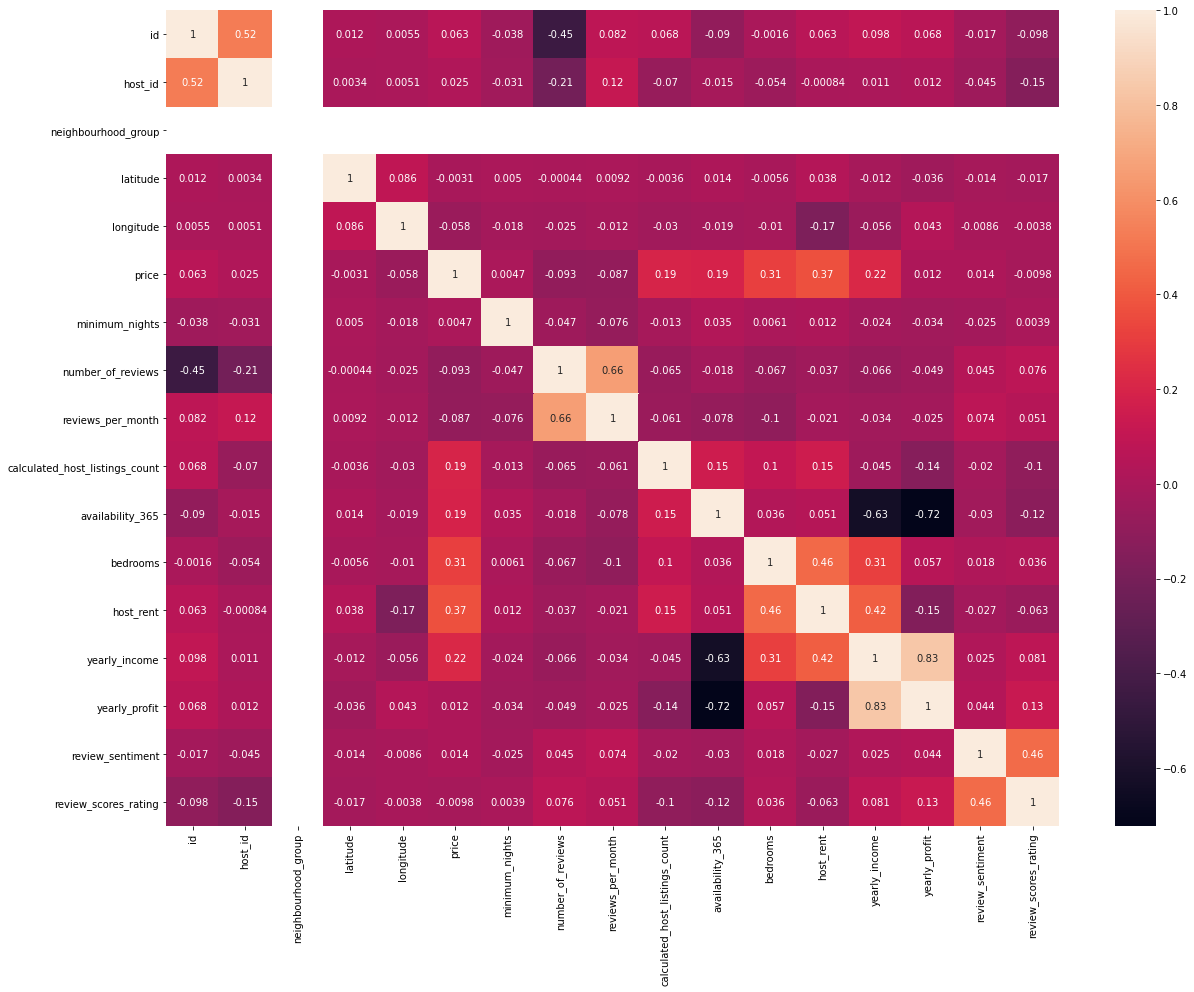

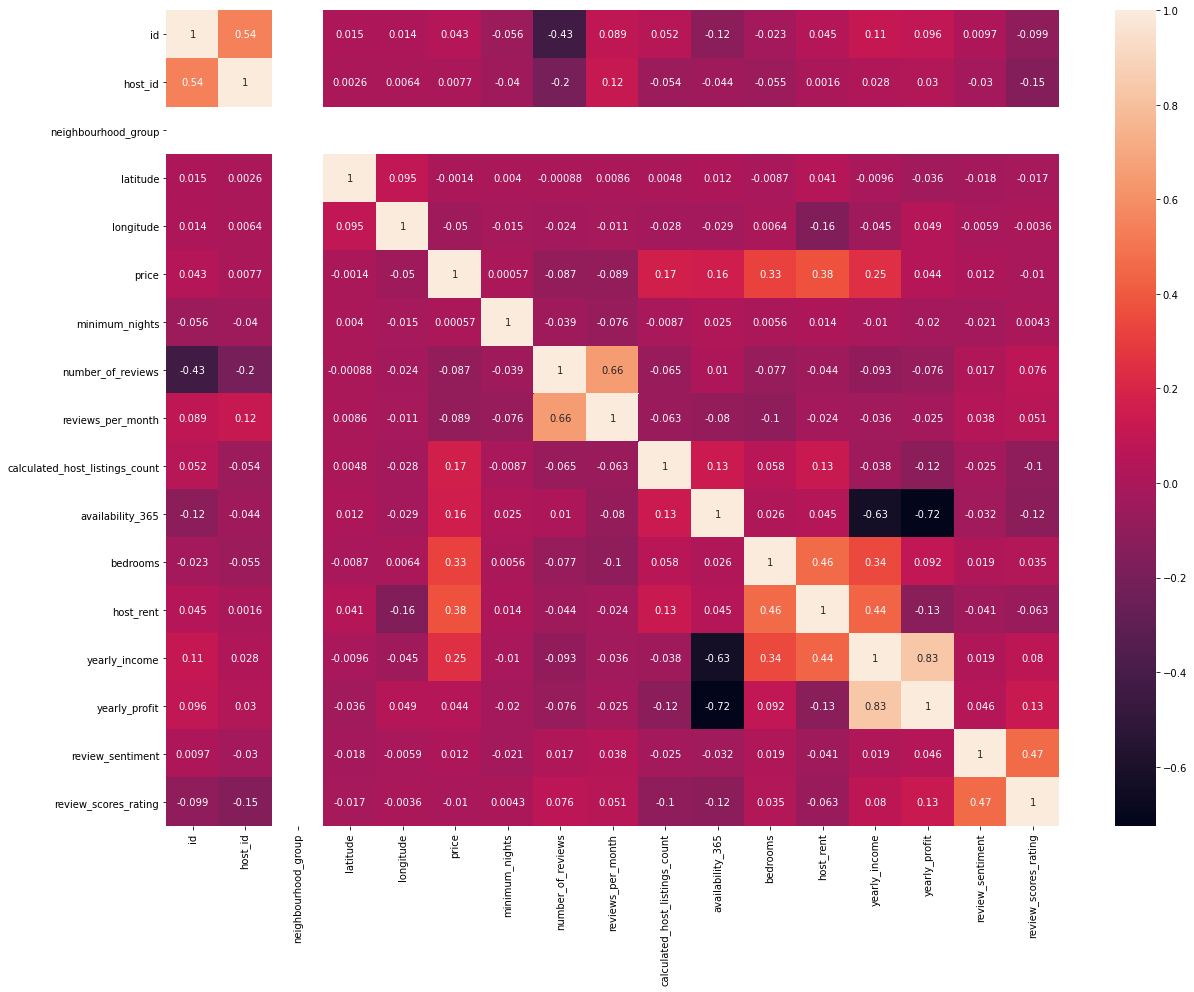

In [14]:
df_num = available_listings_clean.select_dtypes(include=[np.number])
corr_matrix = df_num.corr()
plt.figure(figsize=(20,15))
ax = plt.subplot(111)
sns.heatmap(corr_matrix,  annot = True, ax=ax)

df_num = available_listings_with_reviews_clean.select_dtypes(include=[np.number])
corr_matrix = df_num.corr()
plt.figure(figsize=(20,15))
ax = plt.subplot(111)
sns.heatmap(corr_matrix,  annot = True, ax=ax)

C:\Users\alkonone\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


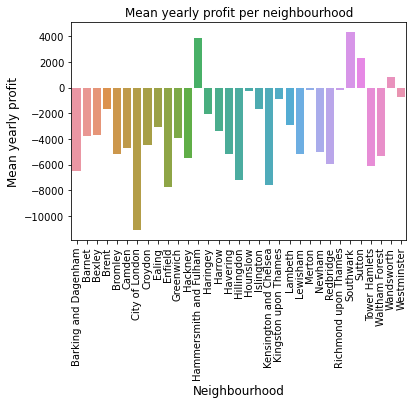

C:\Users\alkonone\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


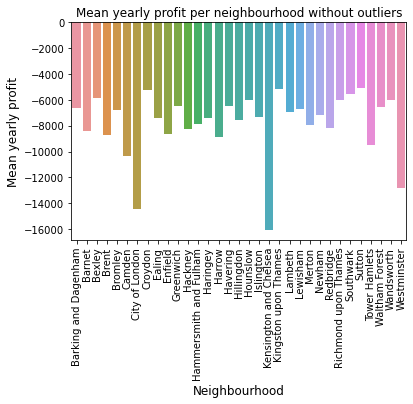

C:\Users\alkonone\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


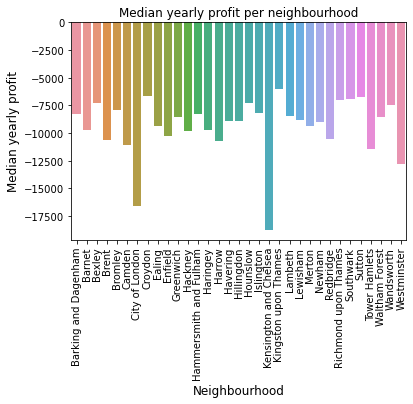

C:\Users\alkonone\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


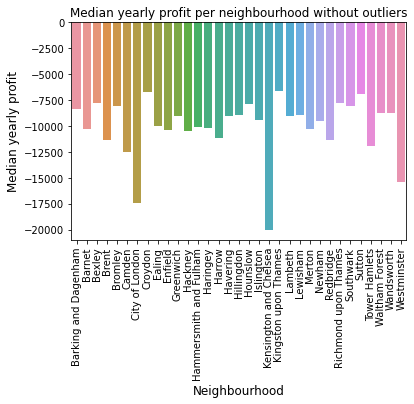

In [15]:
sns.barplot(available_listings.groupby('neighbourhood')['yearly_profit'].mean().index,
            available_listings.groupby('neighbourhood')['yearly_profit'].mean().values)
plt.title('Mean yearly profit per neighbourhood')
plt.ylabel('Mean yearly profit', fontsize=12)
plt.xlabel('Neighbourhood', fontsize=12)
plt.xticks(rotation=90)
plt.show()

sns.barplot(available_listings_clean.groupby('neighbourhood')['yearly_profit'].mean().index,
            available_listings_clean.groupby('neighbourhood')['yearly_profit'].mean().values)
plt.title('Mean yearly profit per neighbourhood without outliers')
plt.ylabel('Mean yearly profit', fontsize=12)
plt.xlabel('Neighbourhood', fontsize=12)
plt.xticks(rotation=90)
plt.show()

sns.barplot(available_listings.groupby('neighbourhood')['yearly_profit'].median().index,
            available_listings.groupby('neighbourhood')['yearly_profit'].median().values)
plt.title('Median yearly profit per neighbourhood')
plt.ylabel('Median yearly profit', fontsize=12)
plt.xlabel('Neighbourhood', fontsize=12)
plt.xticks(rotation=90)
plt.show()

sns.barplot(available_listings_clean.groupby('neighbourhood')['yearly_profit'].median().index,
            available_listings_clean.groupby('neighbourhood')['yearly_profit'].median().values)
plt.title('Median yearly profit per neighbourhood without outliers')
plt.ylabel('Median yearly profit', fontsize=12)
plt.xlabel('Neighbourhood', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [20]:
import geojson
import folium
import geopandas as gpd
#open in geojson
with open ('data/neighbourhoods.geojson') as f:
    
    geoj= geojson.load(f)
    
#open in geopandas    
neighpd = gpd.read_file('data/neighbourhoods.geojson')

In [21]:
#calculate the average profit to display it on London map (neighbourhood)
avg_price = pd.DataFrame(available_listings_clean.groupby("neighbourhood")["yearly_profit"].mean())
listing_count = pd.DataFrame(available_listings_clean.groupby("neighbourhood")["yearly_profit"].count())
listing_count = listing_count.rename(columns={'yearly_profit': 'listing_count'})

#create a deofataframe to have the centroid of each neighbourhood 
gdf= gpd.GeoDataFrame.from_features(neighpd)

gdf['centroid_lon']=gdf['geometry'].centroid.x
gdf['centroid_lat']= gdf['geometry'].centroid.y
gdf.crs={'init':'epsg:2263'}

#we merge our two dataframe 
merge_df = pd.merge(gdf, avg_price, how="inner", on="neighbourhood")
merge_df = pd.merge(merge_df, listing_count, how="inner", on="neighbourhood")
gdf = gdf[gdf['neighbourhood'].isin(merge_df['neighbourhood'])]

merge_df.head()

geometry         neighbourhood  \
0  MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...  Kingston upon Thames   
1  MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...               Croydon   
2  MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...               Bromley   
3  MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...              Hounslow   
4  MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...                Ealing   

  neighbourhood_group  centroid_lon  centroid_lat  yearly_profit  \
0                None     -0.286900     51.387906   -5153.788961   
1                None     -0.087157     51.355335   -5211.352861   
2                None      0.051524     51.371999   -6758.528436   
3                None     -0.367123     51.468378   -6000.326727   
4                None     -0.331026     51.522475   -7396.050468   

   listing_count  
0            308  
1            734  
2            422  
3            666  
4           1089

In [22]:
# create a map
m = folium.Map(location=[np.median(gdf['centroid_lat'].tolist()),

                         np.median(gdf['centroid_lon'].tolist())],

               zoom_start=12)

## add chloropleth layer
m.choropleth(

    geo_data= geoj,

    name='Average yearly profit by London borough',

    data=merge_df,

    columns=['neighbourhood', 'yearly_profit'],

    fill_color='YlGn',
    
    nan_fill_color='white',

    key_on='properties.neighbourhood',

    legend_name='average price',
)

# add markers with basic information
#add markers with biggest touristic attractions
fg = folium.FeatureGroup(name='Neighbouhoods info')

for lat, lon, val, name, count in zip(gdf['centroid_lat'].tolist(),

                               gdf['centroid_lon'].tolist(),

                               merge_df['yearly_profit'].tolist(),

                               gdf['neighbourhood'].tolist(),
                               
                               merge_df['listing_count'].tolist()):   
    html = f"""

    <h3>{name}<\h2><br>

    <h4>avg profit : {int(round(val,0))}  <\h4>
    <h4>number of listings : {int(round(count,0))}  <\h4>

    """
    
    fg.add_child(folium.Marker(location=[lat, lon], popup=html))

m.add_child(fg)
# enable layers to be turned in or out
folium.LayerControl().add_to(m)

m

C:\Users\alkonone\Anaconda3\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [23]:
#dependable variable is yearly_profit so variables that were used in 
#creating yearly_profit variable are dropped in order to mitigate multicollinearity

regression_data = pd.merge(available_listings_clean.drop(['price', 'availability_365', 
                                                          'host_rent', 'yearly_income',
                                                         'neighbourhood_group', 'last_review',
                                                         'host_name','host_id', 'room_type',
                                                         'name','neighbourhood'], axis=1),
                           listings_full[['id', 'accommodates', 'bathrooms','beds']], 
                              how='left', on='id')
regression_data = regression_data.dropna()
regression_data.dtypes

id                                  int64
latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
bedrooms                          float64
yearly_profit                     float64
review_sentiment                  float64
review_scores_rating              float64
accommodates                        int64
bathrooms                         float64
beds                              float64
dtype: object

In [24]:
import statsmodels.api as sm

y = regression_data[['yearly_profit']]
x = regression_data.drop(['yearly_profit'], axis=1)

linear_model = sm.OLS(y, x).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          yearly_profit   R-squared (uncentered):                   0.329
Model:                            OLS   Adj. R-squared (uncentered):              0.329
Method:                 Least Squares   F-statistic:                              1408.
Date:                Sun, 10 Oct 2021   Prob (F-statistic):                        0.00
Time:                        11:05:56   Log-Likelihood:                     -4.0671e+05
No. Observations:               37273   AIC:                                  8.134e+05
Df Residuals:                   37260   BIC:                                  8.135e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
id                                 0.0001   7.45e-06     15.531      0.000       0.000       0.000
latitude                        -547.1347     13.666    -40.035      0.000    -573.921    -520.348
longitude                       6000.7195    722.114      8.310      0.000    4585.355    7416.084
minimum_nights                   -14.4726      3.770     -3.839      0.000     -21.862      -7.083
number_of_reviews                 -6.4851      2.472     -2.624      0.009     -11.330      -1.640
reviews_per_month               -291.1167     84.532     -3.444      0.001    -456.801    -125.432
calculated_host_listings_count   -31.1293      1.269    -24.523      0.000     -33.617     -28.641
bedrooms                         880.2728    128.992      6.824      0.000     627.445    1133.100
review_sentiment               -1905.2491    613.335     -3.106      0.002   -3107.402    -703.096
review_scores_rating             189.1650      7.655     24.711      0.000     174.161     204.169
accommodates                     691.3204     64.060     10.792      0.000     565.760     816.881
bathrooms                      -1108.6471    136.046     -8.149      0.000   -1375.302    -841.992
beds                            -124.0326     91.523     -1.355      0.175    -303.420      55.355
==============================================================================
Omnibus:                      640.429   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              699.736
Skew:                           0.297   Prob(JB):                    1.13e-152
Kurtosis:                       3.312   Cond. No.                     2.90e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.9e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
import pandas as pd
from sklearn import preprocessing

cols = regression_data.columns
x = regression_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = cols
df.head()

id  latitude  longitude  minimum_nights  number_of_reviews  \
0  0.000000  0.717384   0.502278        0.000000           0.025907   
1  0.000034  0.507181   0.426643        0.009009           0.113990   
2  0.000081  0.596424   0.463354        0.002002           0.053109   
3  0.000258  0.399296   0.361495        0.020020           0.044041   
4  0.000260  0.728464   0.374169        0.009009           0.165803   

   reviews_per_month  calculated_host_listings_count  bedrooms  yearly_profit  \
0           0.008660                        0.001079  0.045455       0.326648   
1           0.035660                        0.000000  0.045455       0.404738   
2           0.018849                        0.015102  0.136364       0.172592   
3           0.035150                        0.000000  0.090909       0.570242   
4           0.053490                        0.002157  0.045455       0.408696   

   review_sentiment  review_scores_rating  accommodates  bathrooms      beds  
0          0.697233                0.9625      0.066667   0.090909  0.000000  
1          0.683821                0.9500      0.066667   0.090909  0.047619  
2          0.660042                0.9250      0.333333   0.181818  0.142857  
3          0.679528                0.9125      0.200000   0.090909  0.095238  
4          0.684368                0.9500      0.066667   0.136364  0.000000

In [26]:
y = df[['yearly_profit']]
x = df.drop(['yearly_profit', 'beds'], axis=1)

linear_model = sm.OLS(y, x).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          yearly_profit   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                          2.682e+04
Date:                Sun, 10 Oct 2021   Prob (F-statistic):                        0.00
Time:                        11:05:56   Log-Likelihood:                          13525.
No. Observations:               37273   AIC:                                 -2.703e+04
Df Residuals:                   37261   BIC:                                 -2.692e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
id                                 0.0862      0.004     21.593      0.000       0.078       0.094
latitude                           0.0156      0.007      2.289      0.022       0.002       0.029
longitude                          0.1153      0.007     17.010      0.000       0.102       0.129
minimum_nights                    -0.1159      0.048     -2.427      0.015      -0.210      -0.022
number_of_reviews                  0.0336      0.024      1.399      0.162      -0.013       0.081
reviews_per_month                 -0.1234      0.021     -5.880      0.000      -0.164      -0.082
calculated_host_listings_count    -0.3442      0.015    -23.065      0.000      -0.373      -0.315
bedrooms                           0.2222      0.035      6.276      0.000       0.153       0.292
review_sentiment                   0.2305      0.012     19.238      0.000       0.207       0.254
review_scores_rating               0.2340      0.008     30.754      0.000       0.219       0.249
accommodates                       0.1385      0.010     14.155      0.000       0.119       0.158
bathrooms                         -0.1015      0.019     -5.400      0.000      -0.138      -0.065
==============================================================================
Omnibus:                      574.914   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.322
Skew:                           0.275   Prob(JB):                    4.93e-138
Kurtosis:                       3.324   Cond. No.                         81.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
linear_model.params.sort_values(ascending=False)[:3]

review_scores_rating    0.234037
review_sentiment        0.230510
bedrooms                0.222170
dtype: float64

In [28]:
linear_model.params.sort_values(ascending=False)[-3:]

minimum_nights                   -0.115921
reviews_per_month                -0.123361
calculated_host_listings_count   -0.344179
dtype: float64

# Interactive map with regression analysis to spot most important variables for each London borough


In [29]:
hood_regression_data = pd.merge(available_listings_clean.drop(['price', 'availability_365', 
                                                          'host_rent', 'yearly_income',
                                                         'neighbourhood_group', 'last_review',
                                                         'host_name','host_id', 'room_type',
                                                         'name', 'number_of_reviews',
                                                              'longitude','latitude',
                                                              'reviews_per_month'], axis=1),
                           listings_full[['id', 'accommodates', 'bathrooms']], 
                              how='left', on='id')
hood_regression_data = hood_regression_data.drop(['id'],axis=1)
hood_regression_data.head()

neighbourhood  minimum_nights  calculated_host_listings_count  \
0               Islington               1                               2   
1  Kensington and Chelsea              10                               1   
2             Westminster               3                              15   
3  Hammersmith and Fulham               3                               2   
4              Wandsworth              21                               1   

   bedrooms  yearly_profit  review_sentiment  review_scores_rating  \
0       1.0      -21930.00          0.394466                  97.0   
1       1.0      -15716.00          0.367643                  96.0   
2       3.0      -34188.96          0.320084                  94.0   
3       1.0      -20501.04               NaN                   NaN   
4       2.0       -2546.00          0.359056                  93.0   

   accommodates  bathrooms  
0             2        1.0  
1             2        1.0  
2             6        2.0  
3             2        1.0  
4             4        1.0

In [30]:
with open ('data/neighbourhoods.geojson') as f:
    
    geoj= geojson.load(f)
    
#open in geopandas    
neighpd = gpd.read_file('data/neighbourhoods.geojson')

In [31]:
#calculate the average profit to display it on London map (neighbourhood)
avg_price = pd.DataFrame(available_listings_clean.groupby("neighbourhood")["yearly_profit"].mean())
listing_count = pd.DataFrame(available_listings_clean.groupby("neighbourhood")["yearly_profit"].count())
listing_count = listing_count.rename(columns={'yearly_profit': 'listing_count'})

In [32]:
#  Normalizing data while keeping neighbourhood column intact

hoods = hood_regression_data[['neighbourhood']]
hood_regression_data = hood_regression_data.drop(['neighbourhood'], axis=1)
cols = hood_regression_data.columns
x = hood_regression_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

df.columns = cols
df[['neighbourhood']] = hoods                                                 
df.head()

minimum_nights  calculated_host_listings_count  bedrooms  yearly_profit  \
0        0.000000                        0.001079  0.041667       0.326648   
1        0.008007                        0.000000  0.041667       0.404738   
2        0.001779                        0.015102  0.125000       0.172592   
3        0.001779                        0.001079  0.041667       0.344605   
4        0.017794                        0.000000  0.083333       0.570242   

   review_sentiment  review_scores_rating  accommodates  bathrooms  \
0          0.697233                0.9625      0.032258   0.083333   
1          0.683821                0.9500      0.032258   0.083333   
2          0.660042                0.9250      0.161290   0.166667   
3               NaN                   NaN      0.032258   0.083333   
4          0.679528                0.9125      0.096774   0.083333   

            neighbourhood  
0               Islington  
1  Kensington and Chelsea  
2             Westminster  
3  Hammersmith and Fulham  
4              Wandsworth

In [33]:

grouped_by_hood_regression = df.dropna().groupby('neighbourhood')

neighbourhoods = []
important_positive_variables = []
important_negative_variables = []
for name, group in grouped_by_hood_regression:
    y = group[['yearly_profit']]
    x = group.drop(['yearly_profit', 'neighbourhood'], axis=1)
    
    linear_model = sm.OLS(y, x).fit()
    most_important_positive_variables = linear_model.params.sort_values(ascending=False)[:3].index
    most_important_negative_variables = linear_model.params.sort_values(ascending=True)[:3].index
    
    most_important_positive_variables = ', '.join(most_important_positive_variables.to_list())
    most_important_negative_variables = ', '.join( most_important_negative_variables.to_list())
    
    
    neighbourhoods.append(name)
    important_positive_variables.append(most_important_positive_variables)
    important_negative_variables.append(most_important_negative_variables)
    

important_variables_df = pd.DataFrame(data={'neighbourhood': neighbourhoods, 
                                            'important_positive_variables': important_positive_variables,
                                            'important_negative_variables': important_negative_variables})

important_variables_df.head()


neighbourhood                       important_positive_variables  \
0  Barking and Dagenham            accommodates, minimum_nights, bathrooms   
1                Barnet  review_sentiment, bathrooms, calculated_host_l...   
2                Bexley          accommodates, review_sentiment, bathrooms   
3                 Brent           bedrooms, review_sentiment, accommodates   
4               Bromley          accommodates, review_sentiment, bathrooms   

                        important_negative_variables  
0  calculated_host_listings_count, bedrooms, revi...  
1     review_scores_rating, bedrooms, minimum_nights  
2  calculated_host_listings_count, bedrooms, mini...  
3  calculated_host_listings_count, bathrooms, min...  
4  calculated_host_listings_count, minimum_nights...

In [34]:
#create a deofataframe to have the centroid of each neighbourhood 
gdf= gpd.GeoDataFrame.from_features(neighpd)

gdf['centroid_lon']=gdf['geometry'].centroid.x
gdf['centroid_lat']= gdf['geometry'].centroid.y
gdf.crs={'init':'epsg:2263'}

In [35]:
#we merge our two dataframe 
merge_df = pd.merge(gdf, avg_price, how="inner", on="neighbourhood")
merge_df = pd.merge(merge_df, listing_count, how="inner", on="neighbourhood")
merge_df = pd.merge(merge_df, important_variables_df, how="inner", on="neighbourhood")
gdf = gdf[gdf['neighbourhood'].isin(merge_df['neighbourhood'])]

merge_df.head()

geometry         neighbourhood  \
0  MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...  Kingston upon Thames   
1  MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...               Croydon   
2  MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...               Bromley   
3  MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...              Hounslow   
4  MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...                Ealing   

  neighbourhood_group  centroid_lon  centroid_lat  yearly_profit  \
0                None     -0.286900     51.387906   -5153.788961   
1                None     -0.087157     51.355335   -5211.352861   
2                None      0.051524     51.371999   -6758.528436   
3                None     -0.367123     51.468378   -6000.326727   
4                None     -0.331026     51.522475   -7396.050468   

   listing_count                       important_positive_variables  \
0            308             bedrooms, accommodates, minimum_nights   
1            734  calculated_host_listings_count, accommodates, ...   
2            422          accommodates, review_sentiment, bathrooms   
3            666        minimum_nights, review_sentiment, bathrooms   
4           1089  accommodates, review_sentiment, review_scores_...   

                        important_negative_variables  
0  calculated_host_listings_count, bathrooms, rev...  
1                minimum_nights, bedrooms, bathrooms  
2  calculated_host_listings_count, minimum_nights...  
3  bedrooms, calculated_host_listings_count, revi...  
4  calculated_host_listings_count, bedrooms, bath...

In [36]:
# create a map
m = folium.Map(location=[np.median(gdf['centroid_lat'].tolist()),

                         np.median(gdf['centroid_lon'].tolist())],

               zoom_start=12)

## add chloropleth layer
m.choropleth(

    geo_data= geoj,

    name='Average yearly profit by London borough',

    data=merge_df,

    columns=['neighbourhood', 'yearly_profit'],

    fill_color='YlGn',
    
    nan_fill_color='white',

    key_on='properties.neighbourhood',

    legend_name='Average yearly profiy',
)

# add markers with basic information
#add markers with biggest touristic attractions
fg = folium.FeatureGroup(name='Neighbouhoods info')

for lat, lon, val, name, count, vars_p, vars_n in zip(gdf['centroid_lat'].tolist(),
                                      gdf['centroid_lon'].tolist(),
                                      merge_df['yearly_profit'].tolist(),
                                      gdf['neighbourhood'].tolist(),
                                      merge_df['listing_count'].tolist(),
                                      merge_df['important_positive_variables'].tolist(),
                                      merge_df['important_negative_variables'].tolist()):   
    html = f"""
   
        <style>
        table, th, td {{
          border: 1px solid black;
          padding: 3px;
          text-align: center
        }}
        </style>
        <h3>{name}</h3>
        <table style="width:100%">
       
          <tr>
            <td>Average yearly profit</td>
            <td>{int(round(val,0))}$</td>
          
          </tr>
          <tr>
            <td>Number of listings</td>
            <td>{int(round(count,0))}</td>
            
          </tr>
          <tr>
            <td>Increase in these features results in increase in profit</td>
            <td>{vars_p}</td>
            
          </tr>
          <tr>
            <td>Increase in these features results in decrease in profit</td>
            <td>{vars_n}</td>
            
          </tr>
        </table

    """
    
    fg.add_child(folium.Marker(location=[lat, lon], popup=html))

m.add_child(fg)
# enable layers to be turned in or out
folium.LayerControl().add_to(m)

m

C:\Users\alkonone\Anaconda3\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(
